# Program #2: Predicting Hit Songs using LSTM 🎵

A music streaming company wants to predict whether a newly released song will become a hit based on its first few weeks of streaming data. Early prediction helps the marketing team decide which songs to promote heavily.

This notebook demonstrates how to build a **Long Short-Term Memory (LSTM)** model to forecast if a song will reach the Top 50. LSTMs are a type of Recurrent Neural Network (RNN) especially well-suited for sequence data, like the weekly streaming counts of a song. They can "remember" patterns over long sequences, making them ideal for this task.

We will perform the following steps:
1.  **Generate a Synthetic Dataset**: Create a dataset mimicking the streaming patterns of 'hit' and 'non-hit' songs.
2.  **Preprocess the Data**: Scale and reshape the data to be suitable for an LSTM model.
3.  **Build the LSTM Model**: Construct a neural network using TensorFlow and Keras.
4.  **Train and Evaluate**: Train the model on our data and evaluate its performance using accuracy and a confusion matrix.

---

## 1. Setup and Imports

First, let's import the necessary libraries. We'll need `numpy` and `pandas` for data manipulation, `matplotlib` and `seaborn` for visualization, and `tensorflow` for building our LSTM model.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

---

## 2. Generate Synthetic Dataset

Instead of using a real-world dataset that would require extensive cleaning, we'll generate a synthetic one. This gives us full control and allows us to create clear patterns for the model to learn.

We'll create two types of songs:
-   **Hit Songs (Label 1)**: These songs will show a clear **upward trend** in streams over the first few weeks.
-   **Non-Hit Songs (Label 0)**: These songs will have stagnant or slightly declining streams.

In [26]:
def generate_song_data(num_songs=2000, num_weeks=12):
    """Generates a dataframe of song streaming data."""
    data = []
    
    # Generate half as hits, half as non-hits
    num_hits = num_songs // 2
    num_non_hits = num_songs - num_hits
    
    # Create Hit Songs (upward trend)
    for i in range(num_hits):
        start_streams = np.random.randint(5000, 20000)
        growth_factor = np.random.uniform(1.2, 1.5)
        streams = [start_streams * (growth_factor ** w) + np.random.randint(-2000, 2000) for w in range(num_weeks)]
        data.append([f'Hit_Song_{i}'] + streams + [1]) # Label 1 for hit
    
    # Create Non-Hit Songs (stagnant/decaying trend)
    for i in range(num_non_hits):
        start_streams = np.random.randint(1000, 15000)
        decay_factor = np.random.uniform(0.95, 1.05)
        streams = [start_streams * (decay_factor ** w) + np.random.randint(-1000, 1000) for w in range(num_weeks)]
        data.append([f'NonHit_Song_{i}'] + streams + [0]) # Label 0 for non-hit
        
    # Create DataFrame
    columns = ['song_id'] + [f'week_{w+1}' for w in range(num_weeks)] + ['is_hit']
    df = pd.DataFrame(data, columns=columns)
    return df

# Generate the data
num_weeks = 10 # Using 10 weeks of data to predict
df = generate_song_data(num_songs=5000, num_weeks=num_weeks)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5000, 12)


,song_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,is_hit
0,Hit_Song_0,19732.0,27027.776698,39968.483695,60836.855165,90430.979493,130978.893955,195085.337842,284736.346961,419245.714221,618378.946901,1
1,Hit_Song_1,17357.0,23948.819180,29994.363320,35463.839071,45972.014004,60544.863431,74269.460713,93524.759509,120422.351709,151231.834914,1
2,Hit_Song_2,9376.0,11526.540300,19525.319539,28655.662601,42858.768399,61525.056326,92254.917074,136792.198586,205633.494027,304096.191272,1
3,Hit_Song_3,13773.0,18941.319572,27813.643574,34856.075786,45752.346159,57626.144554,77127.720634,99117.480224,128427.442922,169049.905212,1
4,Hit_Song_4,7433.0,7401.626152,15588.467059,22523.874908,29796.022196,46189.394823,70855.328573,103144.261750,153081.040017,230772.518430,1


---

## 3. Data Exploration & Visualization

Let's visualize the streaming trends of a few sample songs from each category to confirm our data generation logic is sound. We expect to see clear visual differences between the two groups.

/tmp/ipykernel_19885/1220531509.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_19885/1220531509.py:29: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/abhijit-42/miniconda3/envs/tf-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/abhijit-42/miniconda3/envs/tf-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


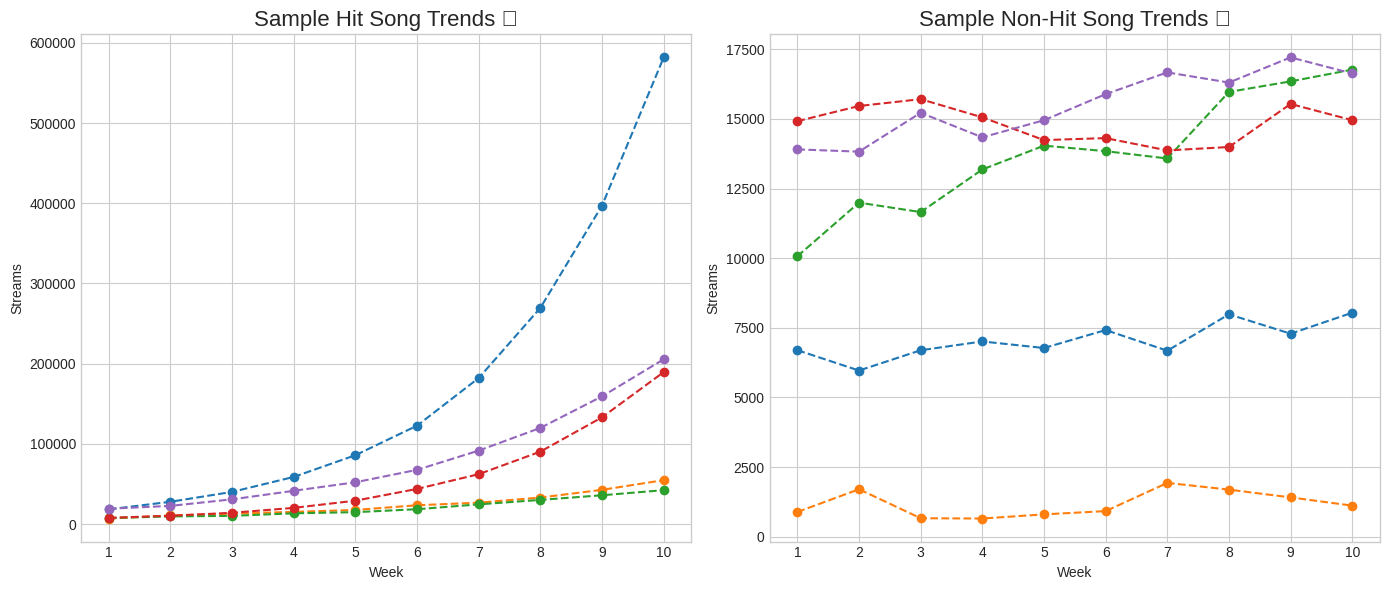

In [27]:
def plot_song_trends(df, num_to_plot=5):
    """Plots streaming trends for sample hit and non-hit songs."""
    hit_samples = df[df['is_hit'] == 1].sample(num_to_plot)
    non_hit_samples = df[df['is_hit'] == 0].sample(num_to_plot)
    
    week_cols = [f'week_{i+1}' for i in range(num_weeks)]
    weeks = np.arange(1, num_weeks + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Hit Songs
    plt.subplot(1, 2, 1)
    for index, row in hit_samples.iterrows():
        plt.plot(weeks, row[week_cols].values, marker='o', linestyle='--')
    plt.title('Sample Hit Song Trends 📈', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Streams')
    plt.xticks(weeks)
    
    # Plot Non-Hit Songs
    plt.subplot(1, 2, 2)
    for index, row in non_hit_samples.iterrows():
        plt.plot(weeks, row[week_cols].values, marker='o', linestyle='--')
    plt.title('Sample Non-Hit Song Trends 📉', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Streams')
    plt.xticks(weeks)
    
    plt.tight_layout()
    plt.show()

plot_song_trends(df)

As expected, the **hit songs** show a consistent upward trajectory, while the **non-hit songs** have much flatter or slightly erratic patterns. This clear distinction is what our LSTM model will learn to recognize.

---

## 4. Data Preprocessing

Before feeding the data into the LSTM, we need to perform two key preprocessing steps:

1.  **Scaling**: Neural networks perform best when input data is scaled to a small range, typically [0, 1]. We will use `MinMaxScaler` for this.
2.  **Reshaping**: LSTMs require input data to be in a specific 3D shape: `(number_of_samples, timesteps, number_of_features)`.
    -   `number_of_samples`: The number of songs in our dataset.
    -   `timesteps`: The number of weeks of data for each song (sequence length).
    -   `number_of_features`: The number of data points we have for each timestep (in our case, just 1: the stream count).

In [28]:
# 1. Separate features (X) and target (y)
week_cols = [f'week_{i+1}' for i in range(num_weeks)]
X = df[week_cols].values
y = df['is_hit'].values

# 2. Scale the features
scaler = MinMaxScaler()
# We scale each song's stream history independently
X_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X])

# 3. Reshape the data for LSTM [samples, timesteps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

print("Original shape:", X.shape)
print("Scaled shape:", X_scaled.shape)
print("Reshaped for LSTM:", X_reshaped.shape)

# 4. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Original shape: (5000, 10)
Scaled shape: (5000, 10)
Reshaped for LSTM: (5000, 10, 1)

Training samples: 4000
Testing samples: 1000


---

## 5. Building the LSTM Model

Now we'll construct our LSTM model using Keras's `Sequential` API. The architecture will be:

1.  **LSTM Layer**: The core of our model. We'll use 50 units, which is a good starting point for capturing the patterns in our sequences.
2.  **Dropout Layer**: A regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 during training.
3.  **Dense Layer**: A standard fully-connected layer with a ReLU activation function.
4.  **Output Layer**: A final `Dense` layer with a single neuron and a **sigmoid** activation function. The sigmoid function outputs a value between 0 and 1, which is perfect for binary classification as it can be interpreted as a probability.

In [29]:
model = Sequential([
    # Input Layer: LSTM with 50 units. 
    # input_shape is (timesteps, features)
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # Dropout layer to prevent overfitting
    Dropout(0.2),
    
    # Hidden Dense layer
    Dense(units=25, activation='relu'),
    
    # Output Layer for binary classification
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Print the model summary
model.summary()

/home/abhijit-42/miniconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

---

## 6. Train the Model

With the model defined, we can now train it on our training data. We'll train for 20 epochs, which means the model will see the entire training dataset 20 times. We also use a `validation_split` to monitor the model's performance on a held-out portion of the training data after each epoch. This is crucial for detecting overfitting.

In [30]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9197 - loss: 0.3496 - val_accuracy: 0.9850 - val_loss: 0.0422
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0480 - val_accuracy: 0.9850 - val_loss: 0.0416
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - loss: 0.0489 - val_accuracy: 0.9875 - val_loss: 0.0434
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0455 - val_accuracy: 0.9837 - val_loss: 0.0534
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.0422 - val_accuracy: 0.9837 - val_loss: 0.0519
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0490 - val_accuracy: 0.9837 - val_loss: 0.0437
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9866 - loss: 0.0456 - val_accuracy: 0.9862 - val_loss: 0.0400
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0445 - val_accuracy: 0.

---

## 7. Evaluate Model Performance

First, let's visualize the model's training and validation accuracy and loss over the epochs. This helps us understand if the model learned effectively and whether it started to overfit.

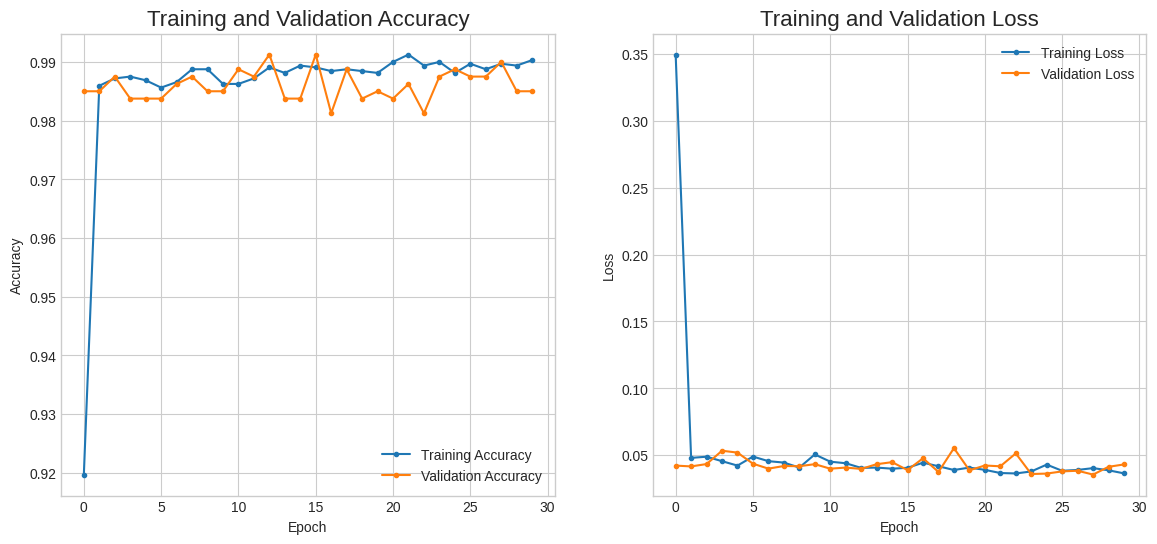

In [31]:
def plot_training_history(history):
    """Plots accuracy and loss for training and validation sets."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='.')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='.')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='.')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='.')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.show()

plot_training_history(history)

The plots show that both training and validation accuracy are high and the losses are low, which is a great sign! The validation and training curves track each other closely, indicating that our model is **not overfitting**.

### Final Evaluation on Test Set

Finally, we evaluate the model on the unseen test data. We'll calculate the final accuracy and visualize a **confusion matrix** to see how well it distinguishes between hit and non-hit songs.

The confusion matrix gives us four key metrics:
-   **True Positives (TP)**: Correctly predicted hits.
-   **True Negatives (TN)**: Correctly predicted non-hits.
-   **False Positives (FP)**: Non-hits incorrectly predicted as hits.
-   **False Negatives (FN)**: Hits incorrectly predicted as non-hits.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Set Accuracy: 0.9900


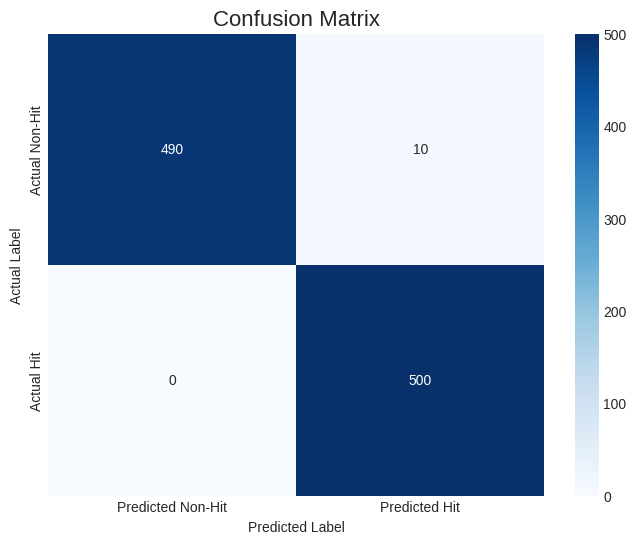

In [32]:
# Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Hit', 'Predicted Hit'], 
            yticklabels=['Actual Non-Hit', 'Actual Hit'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

---

## 8. Conclusion

We successfully built and trained an LSTM model that can predict whether a song will become a hit with very high accuracy based on its initial streaming data.

The model effectively learned the difference between the upward trend of a hit song and the stagnant pattern of a non-hit. The high accuracy and excellent confusion matrix results on the test set demonstrate that this approach is viable for helping a streaming company's marketing team make data-driven decisions.

### Potential Improvements

* **Real-World Data**: Using a real dataset (e.g., from Spotify or Apple Music charts) would make the model more robust.
* **More Features**: We could add other features like song genre, artist popularity, album release date, or even audio features (danceability, energy, loudness) to improve predictive power.
* **Hyperparameter Tuning**: Experimenting with the number of LSTM units, layers, dropout rate, and optimizer could further enhance performance.